# Read in the data

In [2]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


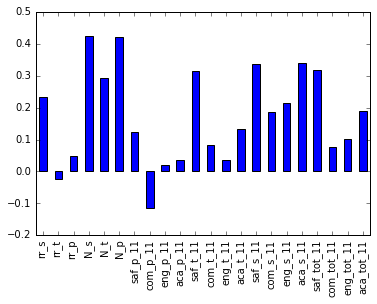

In [12]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

## Findings
There are high correlations between N_s, N_t, N_p and sat_score. Total enrollment is affected by these values so this is sensible.

There are also high correlations between student and teacher perceived safety at school and sat_score. A safe learning environment contributes to better academic performance.

There is high correlation between aca_s and sat_scores. Students tend to be more competitive and perform better if they perceive the academic standards of the school to be high.

# Exploring Safety Scores

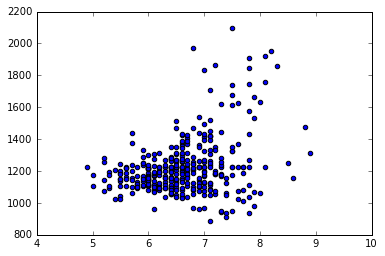

In [13]:
plt.scatter(combined["saf_s_11"],combined["sat_score"])

## Findings
There seems to be a positive correlation between safety and sat_scores. There is a cluster of schools with safety perceptions between 5 and 7 who's SAT scores are below 1600. Schools with the highest SATs have a safety of 7 to 8.5. There are few schools with high safety and SAT scores under 1500.

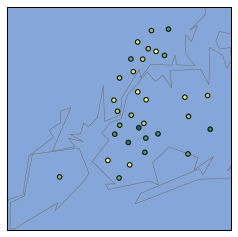

In [21]:
from mpl_toolkits.basemap import Basemap
districts = combined.groupby("school_dist")
districts = districts.agg("mean")

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

## Findings
Districts with low safety are spread throughtout New York with most of these districts being located upper Brooklyn and upper Manhatten. Lowe Manhattan has disrticts with high safety scores as well as Queens.

# Exploring Race

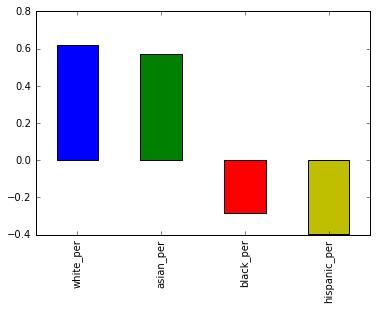

In [24]:
race_fields = ["white_per","asian_per","black_per","hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar(color=["b","g","r","y"])

## Findings
There is a strong positive correlation between white_per and asian_per and sat_score. This suggests the higher whites and asian in student population the higher the SAT scores.

black_per and hispanic_per both show negative correlations. This suggests that as these ethnic groups increase in the student population the SAT score decreases. This opposite is also true.



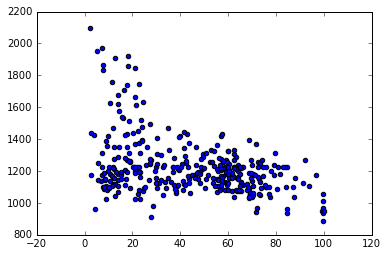

In [25]:
plt.scatter(combined["hispanic_per"],combined["sat_score"])

## Findings
All high sat_score values occur with lower hispanic student polutions. Most hispanic students have sat_scores below 1500.

In [28]:
print(combined[combined["hispanic_per"]>95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [31]:
print(combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


# Exploring Gender

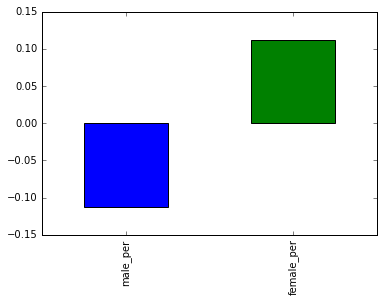

In [32]:
gender_fields = ["male_per","female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar(color=["b","g","r","y"])



## Findings
The correlation between female_per and sat_score is positive though weak whilst that between male_per and sat_score is negative. This suggests that higher female populations would result in higher SAT scores. The converse would also be true.

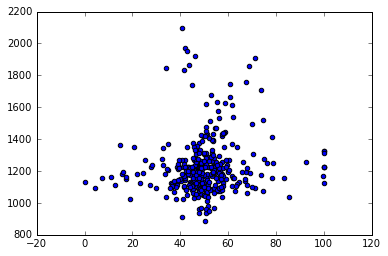

In [33]:
plt.scatter(combined["female_per"],combined["sat_score"])

## Findings
The plot shows an extremely weak correlation between female_per and sat_score. Whilst a cluster of females do well there are points scattered in various directions.

In [35]:
print(combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"])



5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## Findings
These schools appear to have high academic standards

# Exploring Advanced Placement exams 

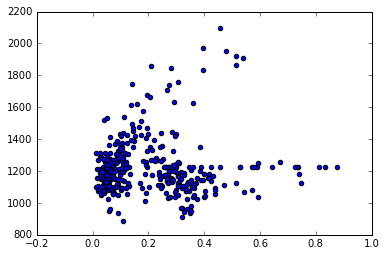

In [36]:
ap_per = combined["AP Test Takers "]/combined["total_enrollment"]
plt.scatter(ap_per,combined["sat_score"])



## Findings
There is a weak correlation between percentage of student who take AP test and SAT scores.

In [39]:
#combined.corr()["sat_score"]["class_size"].plot.bar(color=["b","g","r","y"])
print(combined.head())

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   